### Project: Applying various deep learning models & hyperparameters tuning on CIFAR dataset

#### Import packages
Keras and CIFAR dataset 


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b1afd126-2ebd-f024-4d5c-967fe687d151)


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')


Defining our CIFAR image dimensions with 3 RBG channels, making the overall shape of a image to be 28x28x3

In [2]:
img_rows, img_cols, channels = 32, 32, 3
input_shape=(img_rows,img_cols,channels) # shape of input as a tuple

input_shape

(32, 32, 3)

#### Load data
Load the CIFAR 10 dataset from keras built-in datasets

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


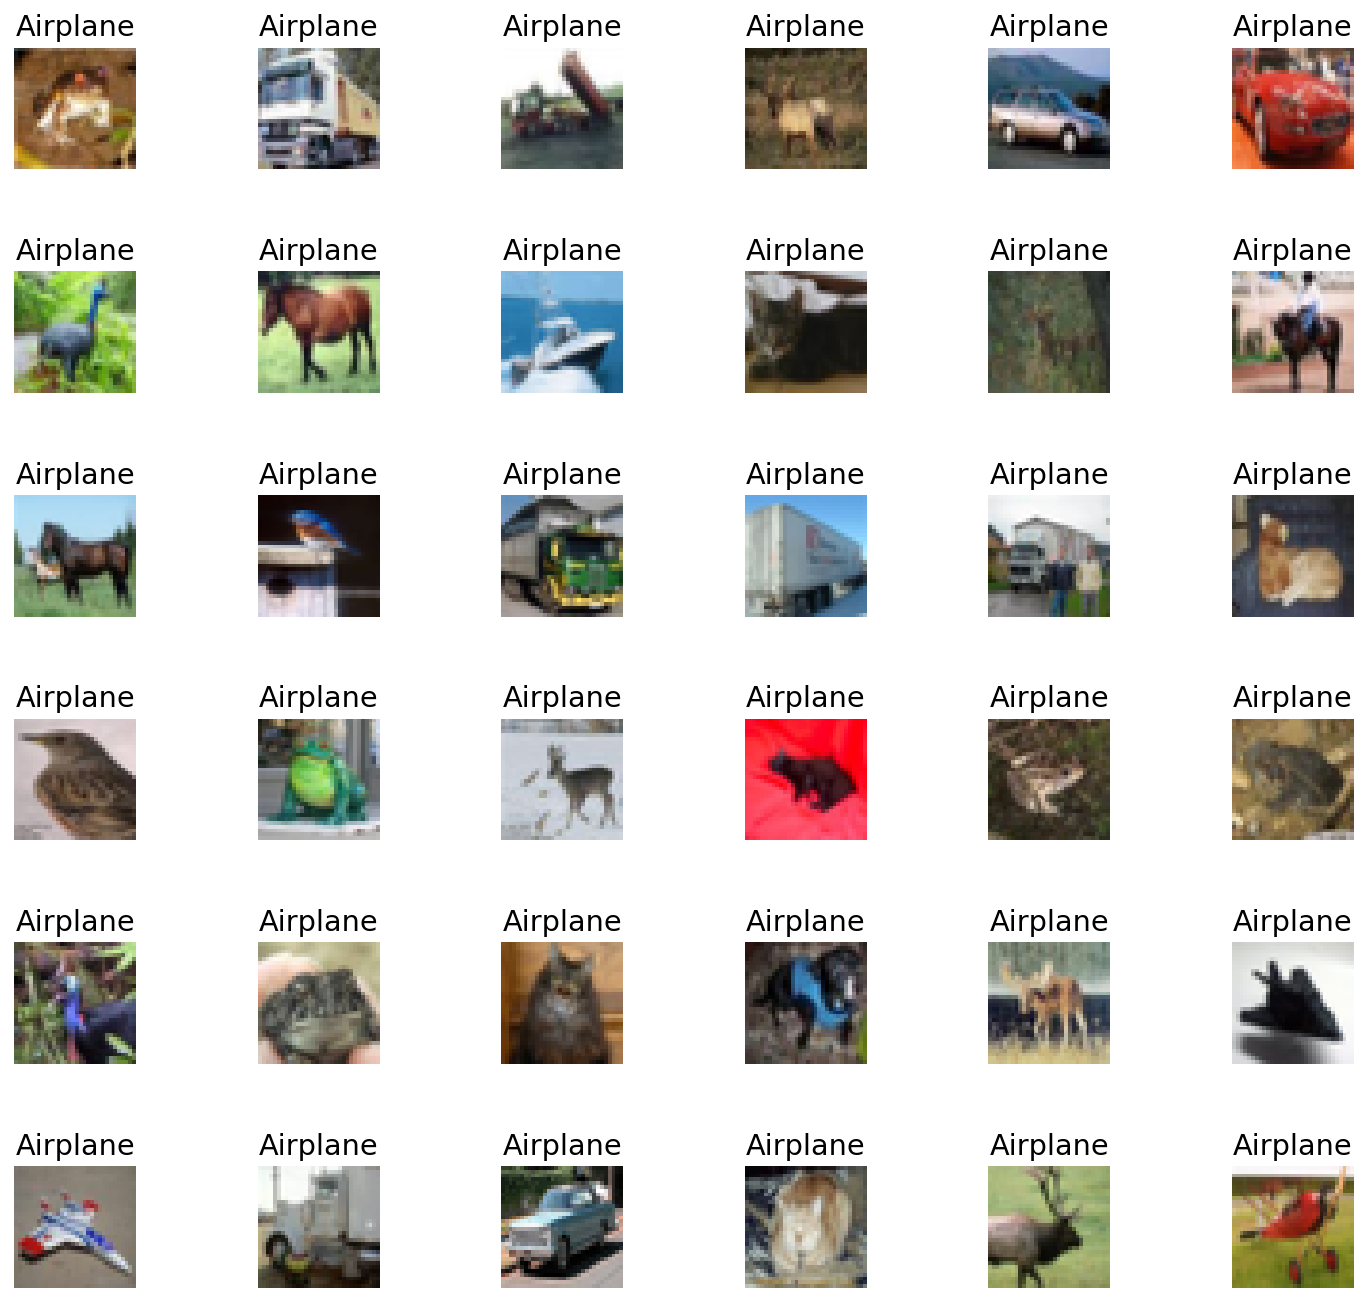

In [5]:
# Visualising the dataset

labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

R = 6
C = 6
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()
Y_true = np.argmax(y_train, axis=1)

for i in np.arange(0, R*C):
    axes[i].imshow(x_train[i])
    axes[i].set_title(labels[Y_true[i]])
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#### Data preprocessing 

Normalisation on x dataset and use one-hot encoding on the categorical values in y

In [6]:
num_classes = 10

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Model 1: Multi-Layer Perceptron

In [20]:
model = keras.Sequential() 

model.add(keras.layers.Dense(128, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.2)) 

model.add(keras.layers.Dense(128, activation='relu')) 
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())
model.add(keras.layers.Dense(num_classes, activation='softmax')) 


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32, 32, 128)       512       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
dense_7 (Dense)              (None, 32, 32, 128)       16512     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)           

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
batch_size = 100
epochs = 100

In [24]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True)

model_log = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=epochs, 
                      validation_split = 0.1,
                      callbacks=[es])

Epoch 1/100
450/450 [==============================] - 12s 25ms/step - loss: 6.9604 - accuracy: 0.3006 - val_loss: 3.5947 - val_accuracy: 0.1716
Epoch 2/100
450/450 [==============================] - 11s 24ms/step - loss: 2.0942 - accuracy: 0.3845 - val_loss: 1.5738 - val_accuracy: 0.4508
Epoch 3/100
450/450 [==============================] - 11s 24ms/step - loss: 1.5435 - accuracy: 0.4581 - val_loss: 1.4987 - val_accuracy: 0.4858
Epoch 4/100
450/450 [==============================] - 11s 24ms/step - loss: 1.4606 - accuracy: 0.4919 - val_loss: 1.4596 - val_accuracy: 0.4954
Epoch 5/100
450/450 [==============================] - 11s 24ms/step - loss: 1.4217 - accuracy: 0.5033 - val_loss: 1.4678 - val_accuracy: 0.4828
Epoch 6/100
450/450 [==============================] - 11s 24ms/step - loss: 1.3973 - accuracy: 0.5148 - val_loss: 1.4464 - val_accuracy: 0.4970
Epoch 7/100
450/450 [==============================] - 11s 24ms/step - loss: 1.3821 - accuracy: 0.5208 - val_loss: 1.4664 - val_ac

In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.450524091720581
Test accuracy: 0.49140000343322754


In [ ]:
model.save("MLPmodel.h5")

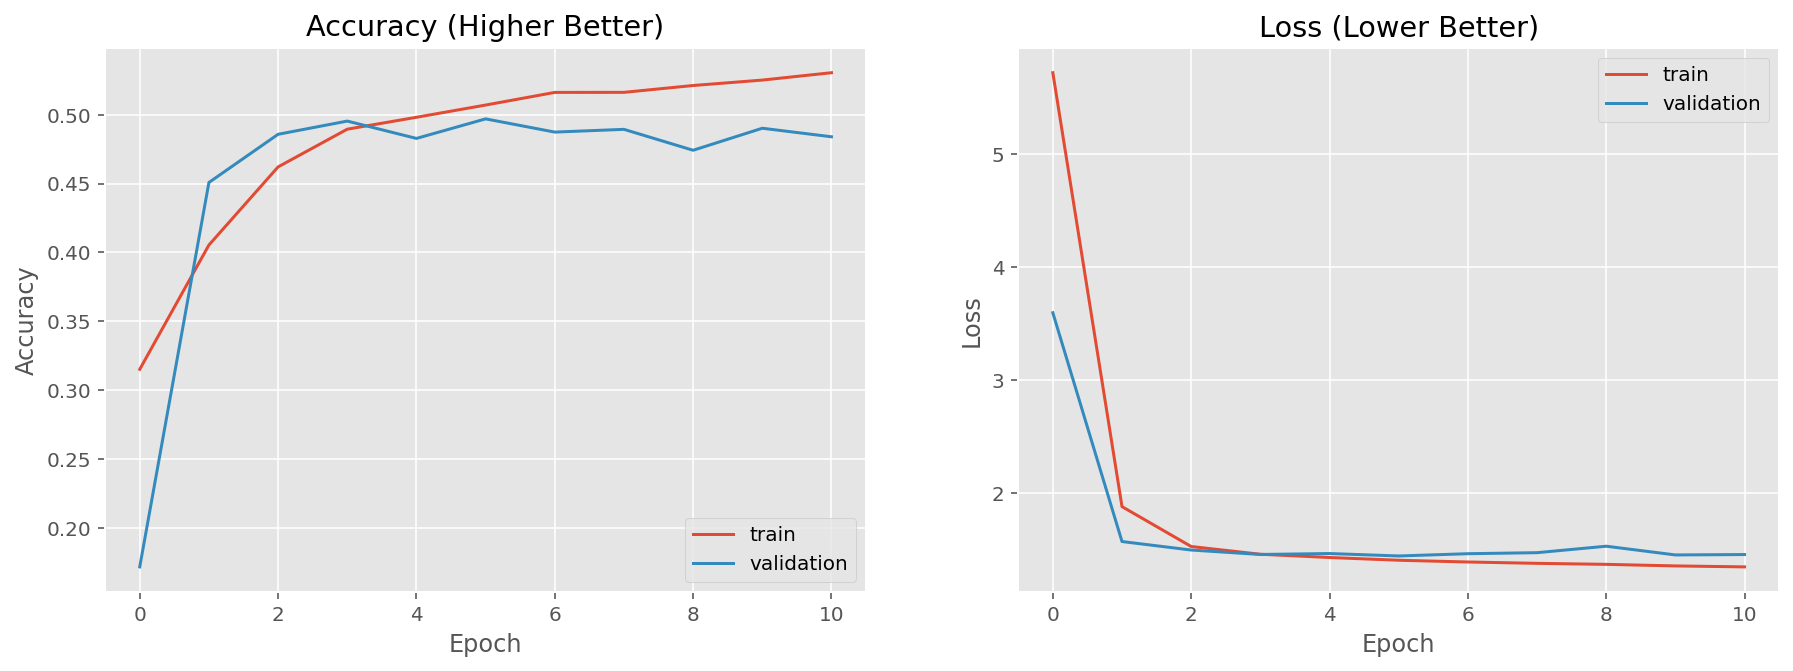

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

### Model 2: Convulational Neural Network with LeNet

In [ ]:
# Lenet-5

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(6, kernel_size=(5,5), 
                        strides=(1,1),
                        padding='same', 
                        input_shape=input_shape,
                        use_bias=True, 
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))

model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(tf.keras.layers.Conv2D(16, kernel_size=(5,5), 
                        padding='valid'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(120, kernel_size=(5,5),
                 padding='valid'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(84))

model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 16)         

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 100
num_classes = 10
epochs = 100

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=10, verbose=1, restore_best_weights=True)

model_log = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=epochs,                     
                      validation_split = 0.1,
                      callbacks=[es]
                     )

Epoch 1/50
450/450 [==============================] - 32s 5ms/step - loss: 1.9666 - accuracy: 0.2709 - val_loss: 1.5181 - val_accuracy: 0.4460
Epoch 2/50
450/450 [==============================] - 2s 4ms/step - loss: 1.5142 - accuracy: 0.4530 - val_loss: 1.3070 - val_accuracy: 0.5216
Epoch 3/50
450/450 [==============================] - 2s 4ms/step - loss: 1.3660 - accuracy: 0.5120 - val_loss: 1.2481 - val_accuracy: 0.5540
Epoch 4/50
450/450 [==============================] - 2s 5ms/step - loss: 1.3037 - accuracy: 0.5308 - val_loss: 1.1796 - val_accuracy: 0.5812
Epoch 5/50
450/450 [==============================] - 2s 4ms/step - loss: 1.2498 - accuracy: 0.5549 - val_loss: 1.1560 - val_accuracy: 0.5920
Epoch 6/50
450/450 [==============================] - 2s 4ms/step - loss: 1.1992 - accuracy: 0.5710 - val_loss: 1.0993 - val_accuracy: 0.6110
Epoch 7/50
450/450 [==============================] - 2s 4ms/step - loss: 1.1676 - accuracy: 0.5849 - val_loss: 1.0892 - val_accuracy: 0.6222
Epoch

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8936426639556885
Test accuracy: 0.6919999718666077


In [ ]:
model.save("CNNmodel.h5")

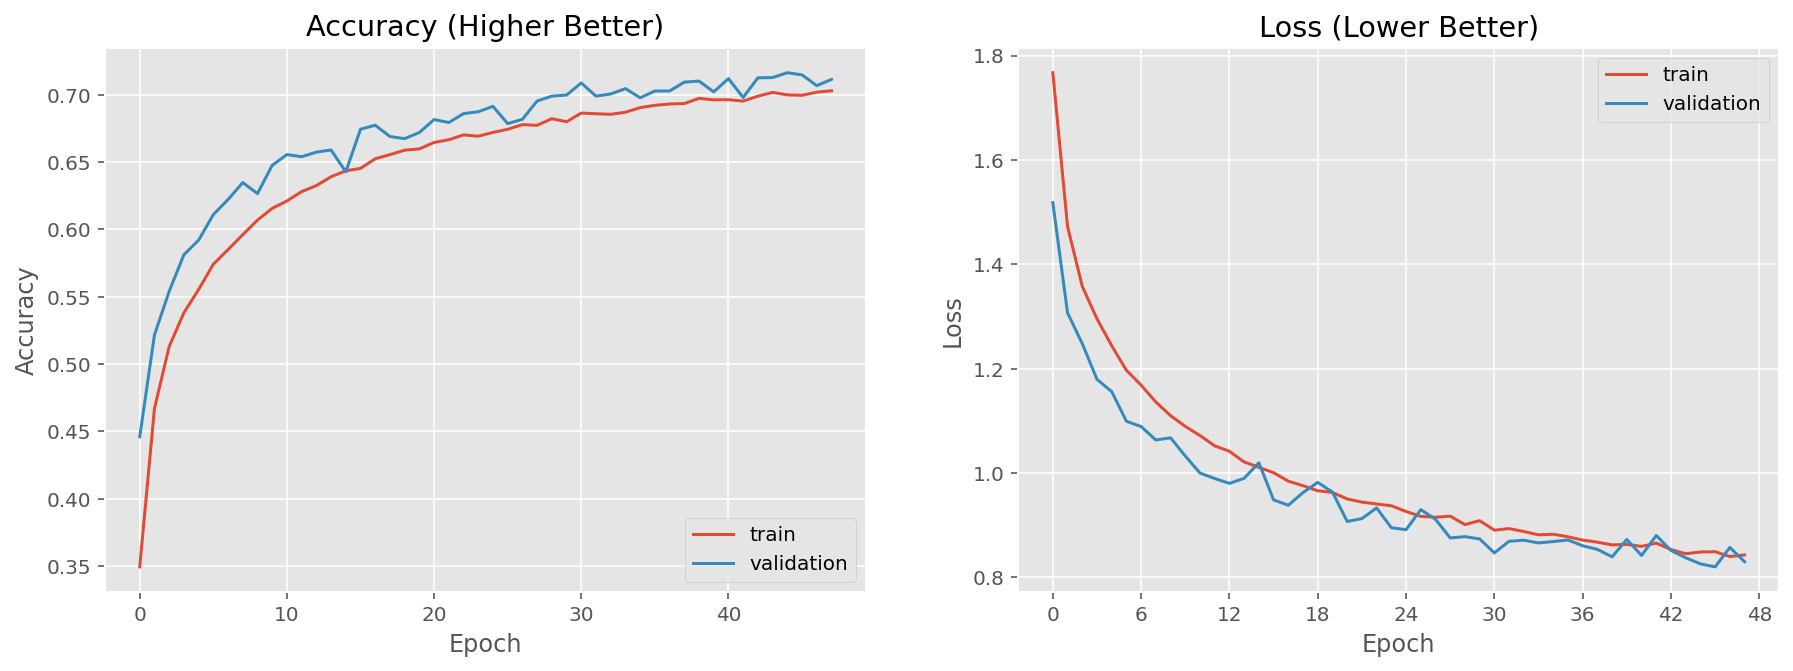

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

### Model 3: Three-Block VGG Architecture

In [ ]:
model = keras.Sequential() 

model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding = 'same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2)) 

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.4)) 
	
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.5)) 
	
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(num_classes, activation='softmax')) 


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 64)      

In [ ]:
# opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer="adam", 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 100
num_classes = 10
epochs = 100

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=10, verbose=1,restore_best_weights=True)

model_log = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=epochs,                     
                      validation_split = 0.1, 
                      callbacks=[es]
                     )

Epoch 1/100
450/450 [==============================] - 7s 13ms/step - loss: 2.1703 - accuracy: 0.3228 - val_loss: 2.2065 - val_accuracy: 0.2778
Epoch 2/100
450/450 [==============================] - 6s 12ms/step - loss: 1.2921 - accuracy: 0.5336 - val_loss: 1.0135 - val_accuracy: 0.6388
Epoch 3/100
450/450 [==============================] - 6s 13ms/step - loss: 1.0433 - accuracy: 0.6285 - val_loss: 0.9237 - val_accuracy: 0.6754
Epoch 4/100
450/450 [==============================] - 6s 13ms/step - loss: 0.9130 - accuracy: 0.6769 - val_loss: 0.9453 - val_accuracy: 0.6742
Epoch 5/100
450/450 [==============================] - 6s 13ms/step - loss: 0.8251 - accuracy: 0.7091 - val_loss: 0.7566 - val_accuracy: 0.7334
Epoch 6/100
450/450 [==============================] - 6s 13ms/step - loss: 0.7512 - accuracy: 0.7383 - val_loss: 0.7229 - val_accuracy: 0.7552
Epoch 7/100
450/450 [==============================] - 6s 12ms/step - loss: 0.6996 - accuracy: 0.7576 - val_loss: 0.6624 - val_accuracy:

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.47637563943862915
Test accuracy: 0.8496999740600586


In [ ]:
model.save("VGGmodel.h5")

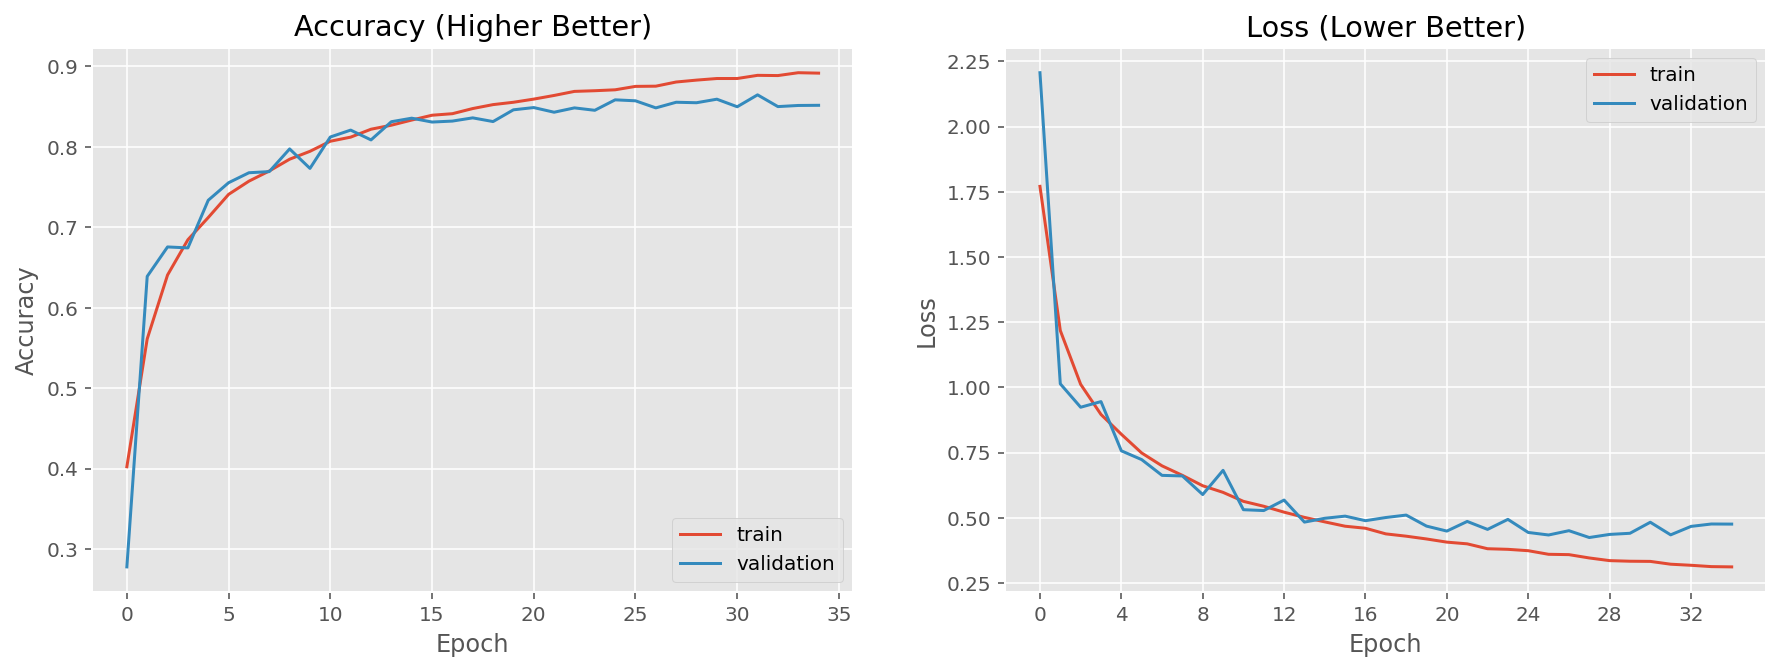

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

### Data Augmentation

Data augmentation using keras Image Data Generator on VGG model

In [13]:
model = keras.Sequential() 

model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding = 'same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2)) 

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.3)) 
	
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.4)) 
	
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(num_classes, activation='softmax')) 

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

In [15]:
# opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer="adam", 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
num_classes = 10
epochs = 100

In [16]:
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.0)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5, verbose=1,restore_best_weights=True)

# fits the model on batches with real-time data augmentation:
model_log=model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) /batch_size, epochs=epochs, 
          validation_data=(x_test,y_test),
          callbacks=[es])

Epoch 1/100
500/500 [==============================] - 26s 50ms/step - loss: 2.1648 - accuracy: 0.3082 - val_loss: 1.5311 - val_accuracy: 0.4442
Epoch 2/100
500/500 [==============================] - 25s 50ms/step - loss: 1.3347 - accuracy: 0.5162 - val_loss: 1.3702 - val_accuracy: 0.5492
Epoch 3/100
500/500 [==============================] - 25s 50ms/step - loss: 1.1237 - accuracy: 0.5979 - val_loss: 0.9982 - val_accuracy: 0.6584
Epoch 4/100
500/500 [==============================] - 24s 49ms/step - loss: 1.0026 - accuracy: 0.6491 - val_loss: 0.8909 - val_accuracy: 0.6901
Epoch 5/100
500/500 [==============================] - 25s 50ms/step - loss: 0.9166 - accuracy: 0.6777 - val_loss: 0.9179 - val_accuracy: 0.6884
Epoch 6/100
500/500 [==============================] - 25s 50ms/step - loss: 0.8550 - accuracy: 0.7046 - val_loss: 0.9841 - val_accuracy: 0.6825
Epoch 7/100
500/500 [==============================] - 25s 50ms/step - loss: 0.7880 - accuracy: 0.7310 - val_loss: 0.7366 - val_ac

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4953373074531555
Test accuracy: 0.8342999815940857


In [ ]:
model.save("DataAugmentVGG.h5")

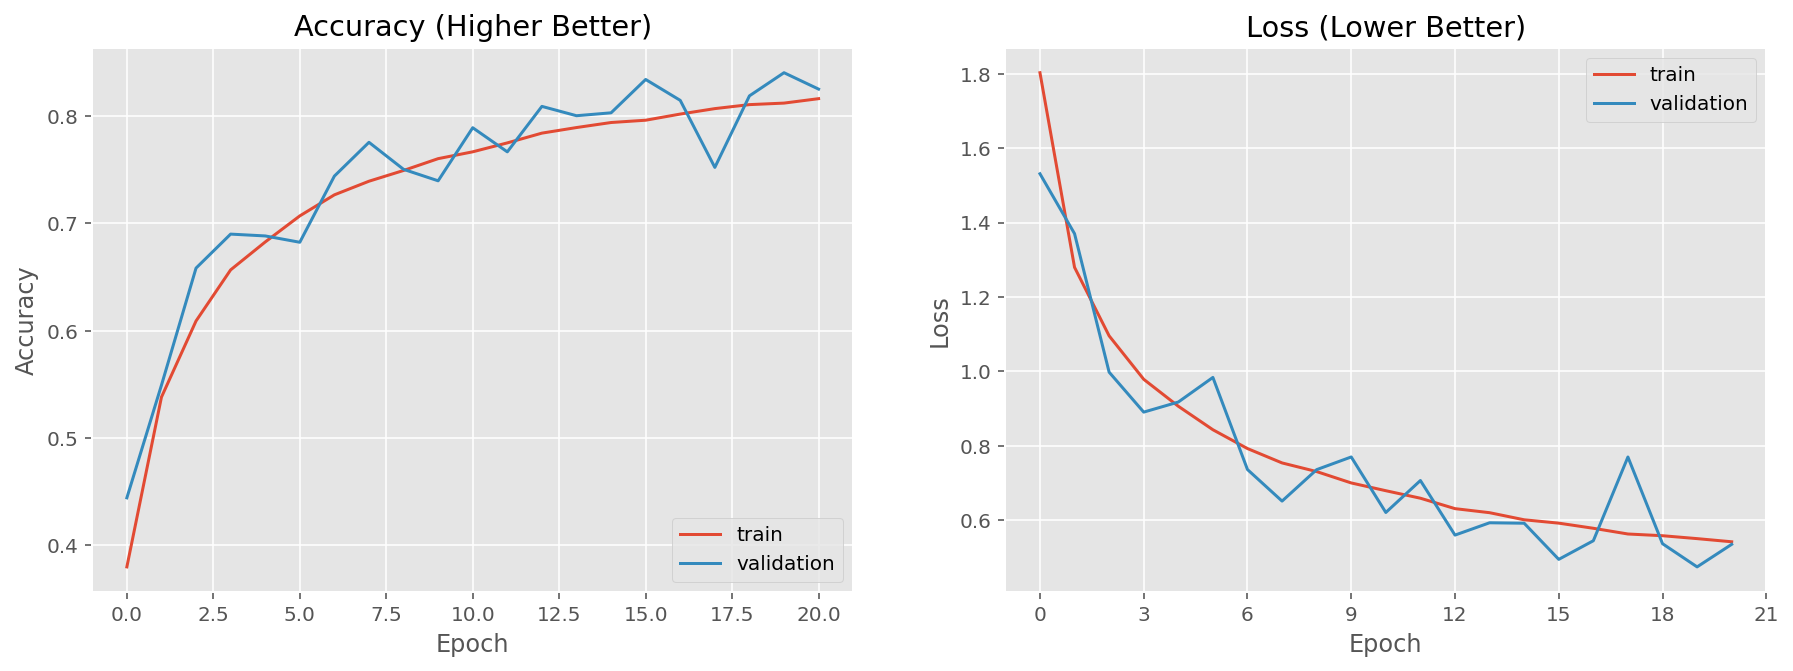

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

#### Check the Predictions

In [ ]:
pred = model.predict(x_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)

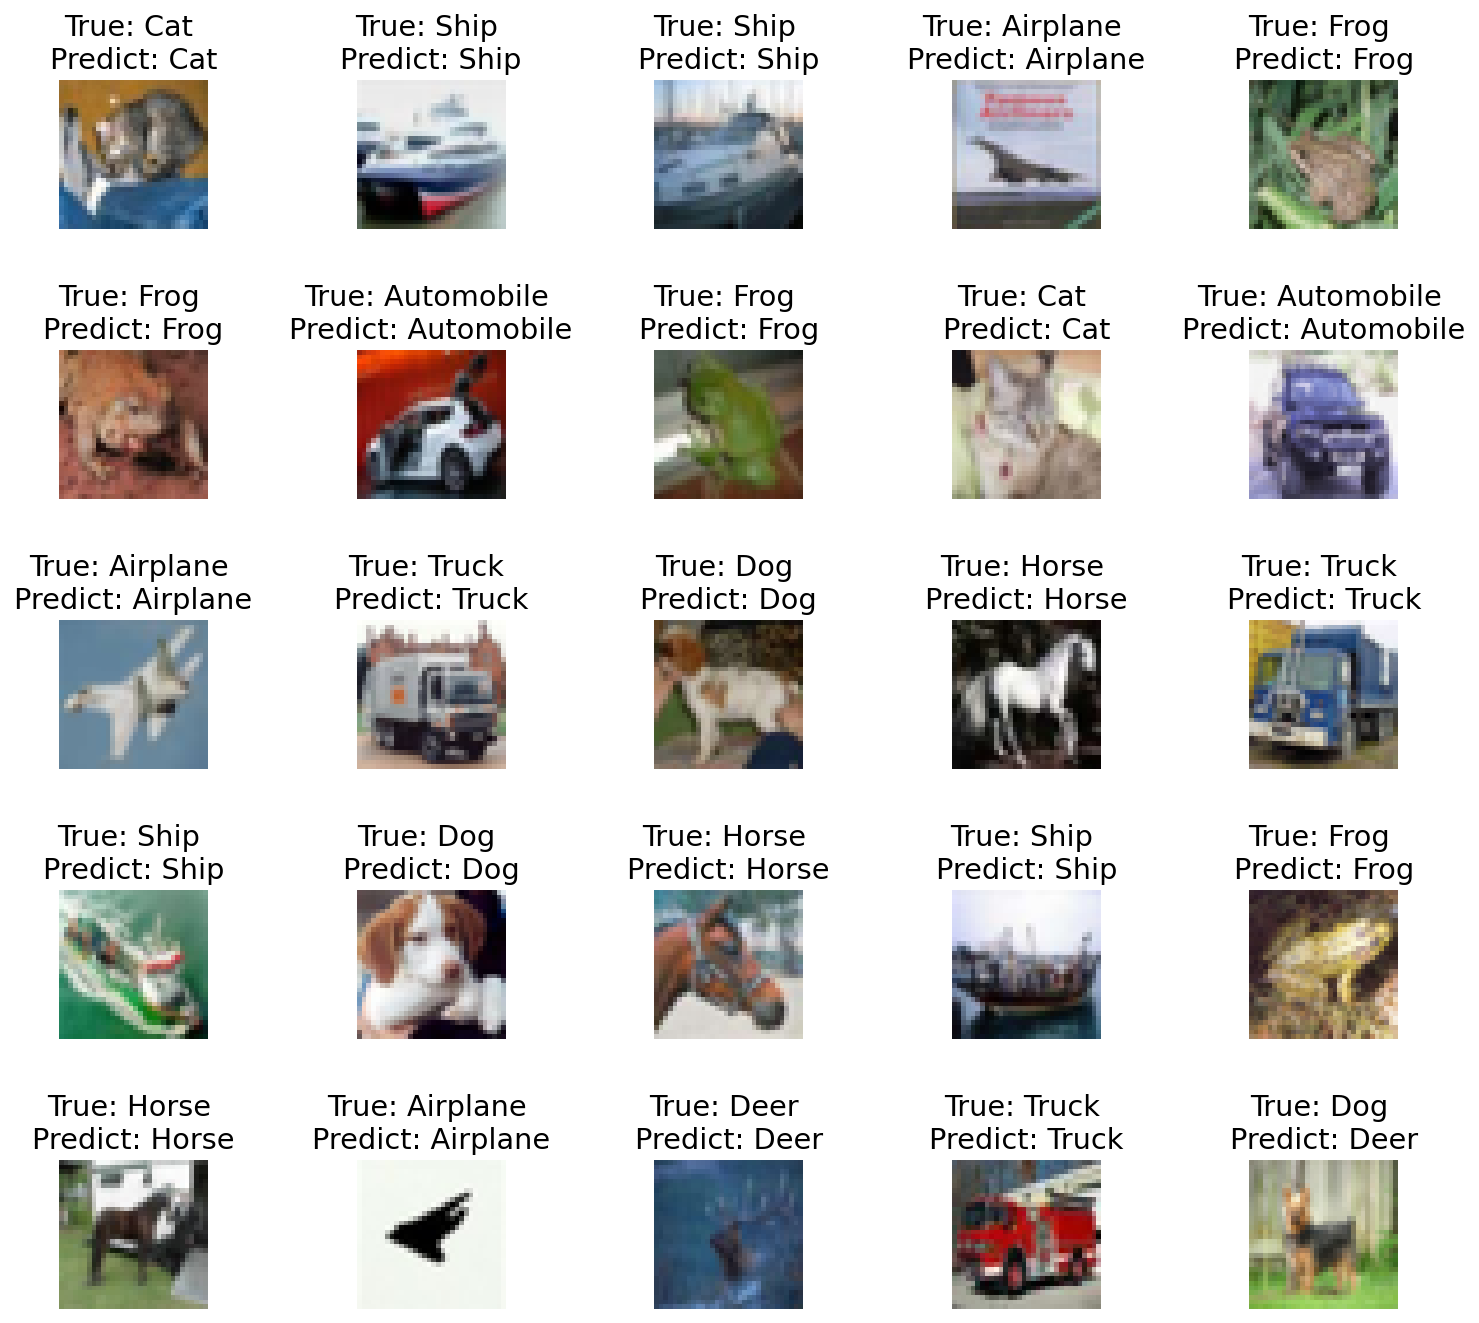

In [ ]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

 ### Check the wrong Predictions

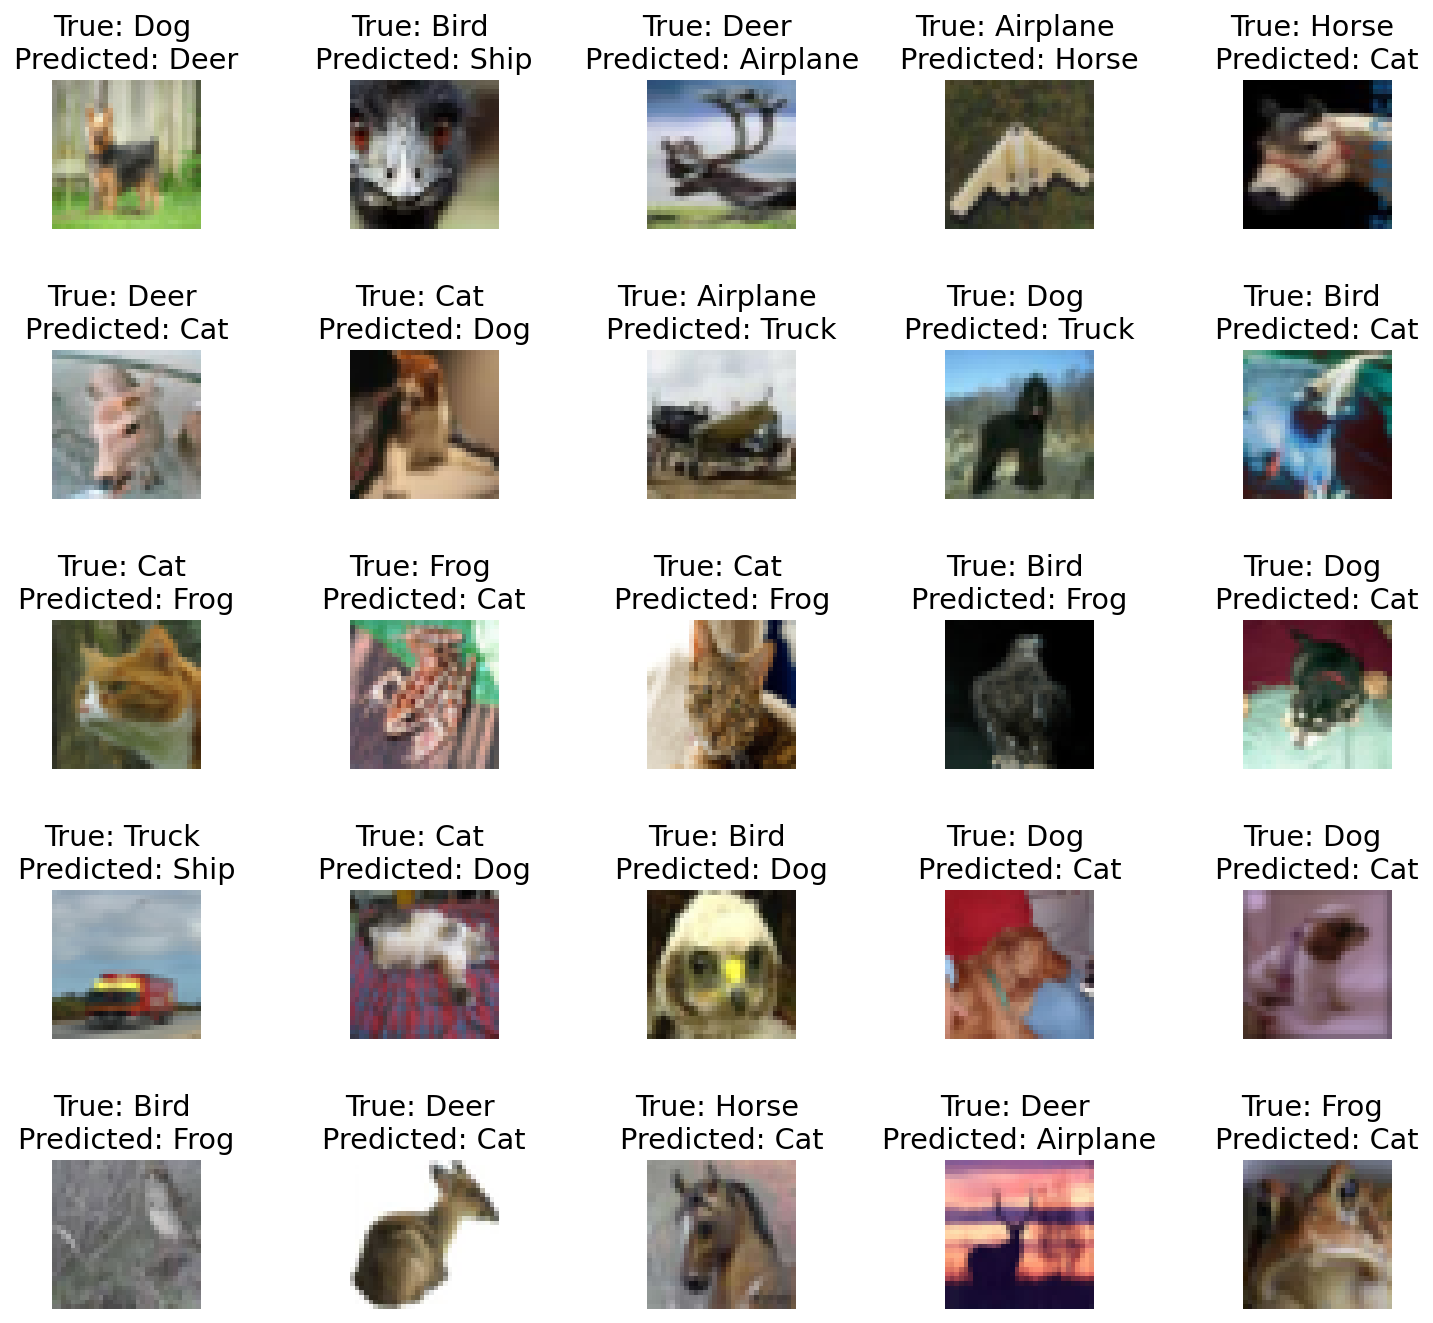

In [ ]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)